In [20]:
import numpy as np
import cv2
from PIL import Image
import sklearn.linear_model  # Import sklearn for RANSACRegressor
from skimage.measure import label, regionprops
from scipy.stats import linregress
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
def preprocess_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply a 3x3 median filter for noise removal
    denoised_image = cv2.medianBlur(image, 3)

    # Apply Otsu's thresholding for binarization
    _, binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binarized_image

In [3]:
def visualize_slant_irregularity(binary_image, original_image, output_path):
    # Dilate the binary image to connect close components
    kernel = np.ones((2,2),np.uint8)
    dilated_image = cv2.dilate(binary_image, kernel, iterations = 1)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated_image, 8, cv2.CV_32S)

    # Create a color version of the original image to draw on
    color_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

    # Iterate through connected components
    for i in range(1, num_labels):  # Start from 1 to exclude background
        # Consider CCs larger than a smaller size than before
        if stats[i, cv2.CC_STAT_AREA] > 5:  # Adjust size threshold as necessary
            # Extract the component
            component_mask = (labels == i).astype(np.uint8) * 255

            # Find coordinates of non-zero pixels
            coords = np.column_stack(np.where(component_mask > 0))

            # Apply a more robust method of line fitting if necessary
            if len(coords) > 1:
                row_coords, col_coords = coords[:, 0], coords[:, 1]
                
                # Use RANSAC or Theil-Sen estimator to handle outliers in fitting
                model = sklearn.linear_model.RANSACRegressor()
                # Reshape data for sklearn
                X = col_coords.reshape(-1, 1)
                y = row_coords
                model.fit(X, y)

                line_X = np.array([X.min(), X.max()]).reshape(-1, 1)
                line_y = model.predict(line_X)

                # Draw the line on the image
                cv2.line(color_image, (line_X[0][0], int(line_y[0])), (line_X[1][0], int(line_y[1])), (0, 255, 0), 2)

    # Save the result to a PNG file
    cv2.imwrite(output_path, color_image)

# Assuming the preprocessed image is already loaded and named 'preprocessed_image'
# Assuming the original image is already loaded and named 'original_image'

image_path = 'images/student_1/w0001_s01_plND_r01.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

preprocessed_image = preprocess_image(image_path)
# Path to save the visualized image
output_path = 'visualizations/character_slants.png'

# Visualize and save the slant irregularity visualization image
visualize_slant_irregularity(preprocessed_image, original_image, output_path)


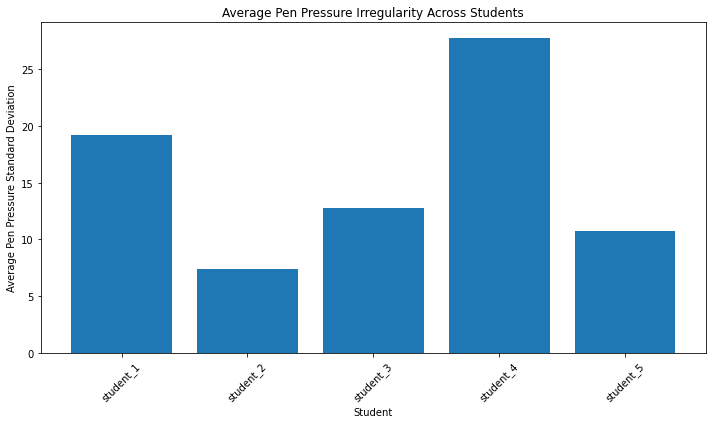

Plot saved to visualizations/average_pen_pressure_irregularity.png


<Figure size 432x288 with 0 Axes>

In [4]:
def calculate_pen_pressure_irregularity(binary_image, square_size=100, num_squares=200):
    image_height, image_width = binary_image.shape
    pen_pressure_sd = []
    
    for _ in range(num_squares):
        x_start = np.random.randint(0, image_width - square_size)
        y_start = np.random.randint(0, image_height - square_size)
        square = binary_image[y_start:y_start + square_size, x_start:x_start + square_size]
        sd = np.std(square)
        pen_pressure_sd.append(sd)
    
    return np.mean(pen_pressure_sd)

# Assuming the student folders are in the current working directory and named 'student_1' to 'student_5'
student_folders = [f'student_{i}' for i in range(1, 6)]
student_irregularities = {}

for student_folder in student_folders:
    student_path = os.path.join('images/', student_folder)  # Update with your path to students' folders
    sd_values = []
    
    for image_name in os.listdir(student_path):
        image_path = os.path.join(student_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_image = cv2.bitwise_not(binary_image)  # Invert if necessary
        average_sd = calculate_pen_pressure_irregularity(binary_image)
        sd_values.append(average_sd)
    
    student_irregularities[student_folder] = np.mean(sd_values)

# Visualization
plt.figure(figsize=(10, 6))
student_numbers = list(student_irregularities.keys())
average_irregularities = list(student_irregularities.values())
plt.bar(student_numbers, average_irregularities)

plt.title('Average Pen Pressure Irregularity Across Students')
plt.xlabel('Student')
plt.ylabel('Average Pen Pressure Standard Deviation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the plot
output_plot_path = 'visualizations/average_pen_pressure_irregularity.png'
plt.savefig(output_plot_path)
print(f"Plot saved to {output_plot_path}")


In [6]:
def highlight_lines(binary_image, original_image):
    # Calculate the horizontal projection profile
    horizontal_projection = np.sum(binary_image == 0, axis=1)
    
    # Find rows that likely represent the start and end of lines
    line_indices = np.where(horizontal_projection > np.max(horizontal_projection) // 2)[0]
    
    # Find breaks between lines based on projection profile
    line_breaks = np.where(np.diff(line_indices) > 1)[0]
    line_start_indices = line_indices[np.insert(line_breaks + 1, 0, 0)]
    line_end_indices = line_indices[np.append(line_breaks, len(line_indices) - 1)]

    # Convert original to color image to draw colored lines
    color_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    
    # Draw horizontal lines on the original image to highlight text lines
    for start, end in zip(line_start_indices, line_end_indices):
        cv2.line(color_image, (0, start), (color_image.shape[1], start), (255, 0, 0), 2)
        cv2.line(color_image, (0, end), (color_image.shape[1], end), (255, 0, 0), 2)
    
    return color_image

# Assuming the binary_image is the preprocessed binary image from your preprocess_image function
# Assuming the original_image is the original grayscale image before preprocessing
# ...

# Call the highlight_lines function
highlighted_image = highlight_lines(preprocessed_image, original_image)

# Save the highlighted image, if needed
cv2.imwrite('visualizations/line-regions.png', highlighted_image)


True

In [9]:
import cv2
import numpy as np

def highlight_lines(binary_image, original_image):
    # Calculate the horizontal projection profile
    horizontal_projection = np.sum(binary_image == 0, axis=1)
    
    # Find rows that likely represent the start and end of lines
    line_indices = np.where(horizontal_projection > np.max(horizontal_projection) // 2)[0]
    
    # Find breaks between lines based on projection profile
    line_breaks = np.where(np.diff(line_indices) > 1)[0]
    line_start_indices = line_indices[np.insert(line_breaks + 1, 0, 0)]
    line_end_indices = line_indices[np.append(line_breaks, len(line_indices) - 1)]
    
    # Convert original to color image to draw colored lines
    color_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    
    # Draw horizontal lines on the original image to highlight text lines
    for start, end in zip(line_start_indices, line_end_indices):
        # Draw the top line
        cv2.line(color_image, (0, start), (color_image.shape[1], start), (255, 0, 0), 2)
        
        # Draw the bottom line
        cv2.line(color_image, (0, end), (color_image.shape[1], end), (255, 0, 0), 2)
        
        # Calculate the middle line
        middle = start + (end - start) // 2
        cv2.line(color_image, (0, middle), (color_image.shape[1], middle), (0, 255, 0), 2)
    
    return color_image

# Use your preprocessed binary image and original image here
# preprocessed_image = <your_binary_image>
# original_image = <your_grayscale_image>

# Call the highlight_lines function
highlighted_image = highlight_lines(preprocessed_image, original_image)

# Specify the path to save the highlighted image
output_path = 'visualizations/highlighted_lines.png'
cv2.imwrite(output_path, highlighted_image)


True

In [11]:
def group_lines_and_calculate_distances(binary_image, original_image):
    # Calculate the horizontal projection profile
    horizontal_projection = np.sum(binary_image == 0, axis=1)
    
    # Find rows that likely represent the start and end of lines
    line_indices = np.where(horizontal_projection > np.max(horizontal_projection) // 2)[0]
    
    # Find breaks between lines based on projection profile
    line_breaks = np.where(np.diff(line_indices) > 1)[0]
    line_start_indices = line_indices[np.insert(line_breaks + 1, 0, 0)]
    line_end_indices = line_indices[np.append(line_breaks, len(line_indices) - 1)]

    # Group lines and calculate distances
    line_groups = []
    for start, end in zip(line_start_indices, line_end_indices):
        middle = start + (end - start) // 2
        distance = end - start
        line_groups.append((start, middle, end, distance))
    
    # Filter out groups with small distances
    # Determine the threshold as a fraction of the average distance
    average_distance = np.mean([group[3] for group in line_groups])
    threshold_distance = average_distance * 0.5  # 50% of the average distance

    filtered_groups = [group for group in line_groups if group[3] > threshold_distance]

    return filtered_groups

def visualize_line_groups(filtered_groups, original_image, output_path):
    # Convert original to color image to draw colored lines
    color_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

    # Draw lines for each group
    for top, middle, bottom, _ in filtered_groups:
        cv2.line(color_image, (0, top), (color_image.shape[1], top), (255, 0, 0), 2)  # Top line
        cv2.line(color_image, (0, middle), (color_image.shape[1], middle), (0, 255, 0), 2)  # Middle line
        cv2.line(color_image, (0, bottom), (color_image.shape[1], bottom), (0, 0, 255), 2)  # Bottom line

    # Save the visualized image
    cv2.imwrite(output_path, color_image)

# Assuming 'preprocessed_image' is your binary image and 'original_image' is your grayscale image
filtered_groups = group_lines_and_calculate_distances(preprocessed_image, original_image)

# Specify the path to save the visualized image
output_path = 'visualizations/filtered_line_groups.png'
visualize_line_groups(filtered_groups, original_image, output_path)


In [12]:
def calculate_distances(filtered_groups):
    # Calculate the average distance between top and bottom lines for each group
    top_bottom_distances = [group[2] - group[0] for group in filtered_groups]
    average_top_bottom_distance = np.mean(top_bottom_distances)

    # Calculate the average distance between adjacent middle lines
    middle_distances = [filtered_groups[i+1][1] - filtered_groups[i][1] for i in range(len(filtered_groups)-1)]
    average_middle_distance = np.mean(middle_distances)

    return average_top_bottom_distance, average_middle_distance

# Assuming 'filtered_groups' contains the filtered line groupings from the previous step
average_top_bottom_distance, average_middle_distance = calculate_distances(filtered_groups)

print(f"Average distance between top and bottom lines: {average_top_bottom_distance:.2f} pixels")
print(f"Average distance between adjacent middle lines: {average_middle_distance:.2f} pixels")


Average distance between top and bottom lines: 33.40 pixels
Average distance between adjacent middle lines: 118.22 pixels


In [17]:
# Define paths and parameters
students_folder = 'images/'

# Initialize lists or DataFrame to store results
results = []

# Loop through each student folder
for student_folder in os.listdir(students_folder):
    student_path = os.path.join(students_folder, student_folder)
    if os.path.isdir(student_path):
        # Loop through each image in the student folder
        for image_name in os.listdir(student_path):
            image_path = os.path.join(student_path, image_name)
            
            # Load the image and preprocess it
            preprocessed_image = preprocess_image(image_path)  # Assuming you have a preprocess_image function
            
            # Group lines and calculate distances
            filtered_groups = group_lines_and_calculate_distances(preprocessed_image, original_image)
            
            # Calculate distances and store results
            average_top_bottom_distance, average_middle_distance = calculate_distances(filtered_groups)
            results.append({
                'Student': student_folder,
                'Image': image_name,
                'Avg Top-Bottom Distance': average_top_bottom_distance,
                'Avg Middle Distance': average_middle_distance
            })

# Convert results to DataFrame for easier manipulation and visualization
results_df = pd.DataFrame(results)


/Users/arnavk/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/arnavk/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
results_df.head()

,Student,Image,Avg Top-Bottom Distance,Avg Middle Distance
0,student_4,w0004_s01_pLND_r02.png,14.750000,222.857143
1,student_4,w0004_s01_pLND_r03.png,35.454545,192.500000
2,student_4,w0004_s01_pLND_r01.png,21.450000,68.105263
3,student_4,w0004_s03_pPHR_r03.png,10.714286,123.166667
4,student_4,w0004_s02_pWOZ_r03.png,40.153846,192.916667


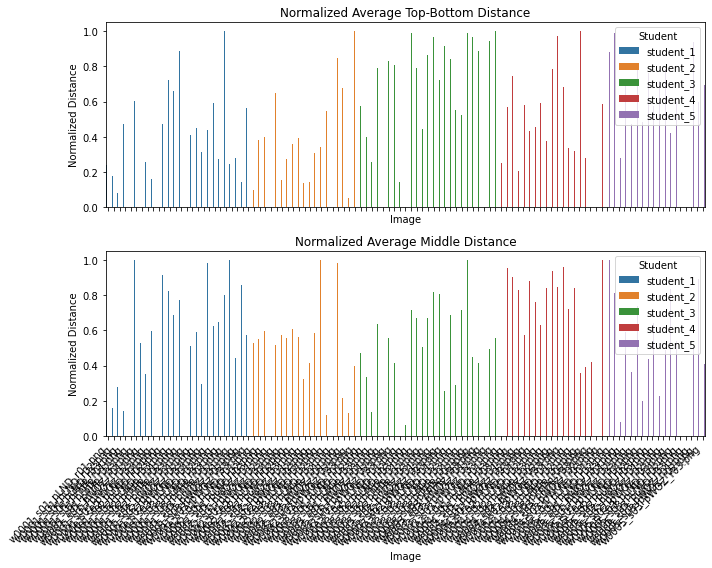

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Remove outliers for 'Avg Top-Bottom Distance' and 'Avg Middle Distance' columns
results_no_outliers = remove_outliers(results_df, 'Avg Top-Bottom Distance')
results_no_outliers = remove_outliers(results_no_outliers, 'Avg Middle Distance')

# Calculate normalized values within each student group
results_no_outliers['Norm Avg Top-Bottom'] = results_no_outliers.groupby('Student')['Avg Top-Bottom Distance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
results_no_outliers['Norm Avg Middle'] = results_no_outliers.groupby('Student')['Avg Middle Distance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Set up the figure and axes for plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot normalized average top-bottom distance with error bars
sns.barplot(x='Image', y='Norm Avg Top-Bottom', hue='Student', data=results_no_outliers, ax=axs[0], ci='sd')
axs[0].set_title('Normalized Average Top-Bottom Distance')
axs[0].set_ylabel('Normalized Distance')
axs[0].legend(title='Student', loc='upper right')

# Plot normalized average middle distance with error bars
sns.barplot(x='Image', y='Norm Avg Middle', hue='Student', data=results_no_outliers, ax=axs[1], ci='sd')
axs[1].set_title('Normalized Average Middle Distance')
axs[1].set_ylabel('Normalized Distance')
axs[1].set_xlabel('Image')
axs[1].legend(title='Student', loc='upper right')

# Rotate x-axis labels for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


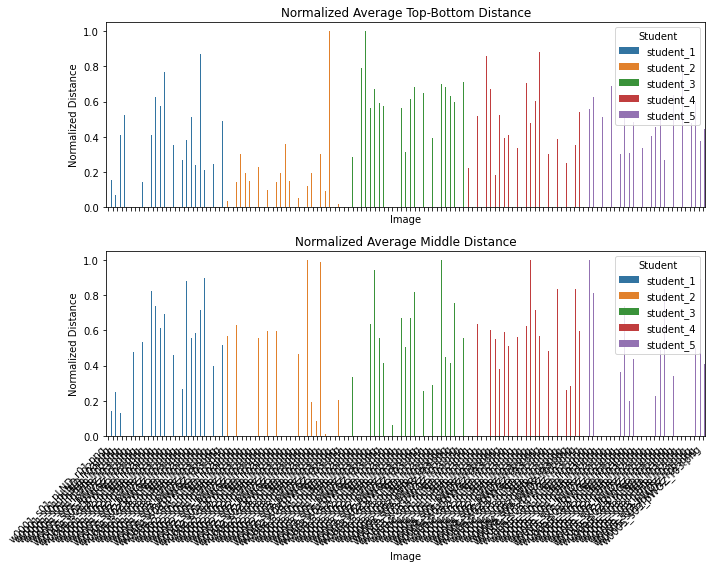

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate normalized values within each student group
results_df['Norm Avg Top-Bottom'] = results_df.groupby('Student')['Avg Top-Bottom Distance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
results_df['Norm Avg Middle'] = results_df.groupby('Student')['Avg Middle Distance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Set up the figure and axes for plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot normalized average top-bottom distance with error bars
sns.barplot(x='Image', y='Norm Avg Top-Bottom', hue='Student', data=results_df, ax=axs[0], ci='sd')
axs[0].set_title('Normalized Average Top-Bottom Distance')
axs[0].set_ylabel('Normalized Distance')
axs[0].legend(title='Student', loc='upper right')

# Plot normalized average middle distance with error bars
sns.barplot(x='Image', y='Norm Avg Middle', hue='Student', data=results_df, ax=axs[1], ci='sd')
axs[1].set_title('Normalized Average Middle Distance')
axs[1].set_ylabel('Normalized Distance')
axs[1].set_xlabel('Image')
axs[1].legend(title='Student', loc='upper right')

# Rotate x-axis labels for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [32]:


# Directory containing the images
input_directory = 'cleaned_characters/student_1'
# Directory where the processed images will be saved
output_directory = 'canny_edge'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
# Initialize an empty list to store the edge data
all_edges = []

# Iterate over all the images in the directory
for filename in os.listdir(input_directory):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Read the image
        img_path = os.path.join(input_directory, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply Canny edge detection
        edges = cv2.Canny(image, 100, 200)
        
        # Save the processed image
        output_image_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_image_path, edges)

        # Flatten the edge data and append it to the list
        all_edges.append(edges.flatten())

# Convert the list of edges to a DataFrame
edge_data = pd.DataFrame(all_edges)

# Save the DataFrame to a CSV file
output_csv_path = os.path.join(output_directory, 'all_edges.csv')
edge_data.to_csv(output_csv_path, index=False, header=False)
print("Processing complete. Check the output directory for the results.")


Processing complete. Check the output directory for the results.


In [35]:
def sobel_edge_detection(input_directory, output_directory):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Initialize an empty list to store the edge data
    all_edges = []

    # Iterate over all the images in the directory
    for filename in os.listdir(input_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Read the image
            img_path = os.path.join(input_directory, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Apply Sobel edge detection
            sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
            sobel = cv2.magnitude(sobelx, sobely)
            
            # Normalize and convert to 8-bit format
            sobel_norm = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            
            # Save the processed image
            output_image_path = os.path.join(output_directory, filename)
            cv2.imwrite(output_image_path, sobel_norm)

            # Flatten the edge data and append it to the list
            all_edges.append(sobel_norm.flatten())

    # Convert the list of edges to a DataFrame
    edge_data = pd.DataFrame(all_edges)

    # Save the DataFrame to a CSV file
    output_csv_path = os.path.join(output_directory, 'sobel_edges.csv')
    edge_data.to_csv(output_csv_path, index=False, header=False)
    print("Sobel edge processing complete. Check the output directory for the results.")

# Example usage
input_directory = 'cleaned_characters/student_1'
output_directory = 'sobel_edge'
sobel_edge_detection(input_directory, output_directory)


Sobel edge processing complete. Check the output directory for the results.


Mean edge values:
0      11.434667
1      33.597981
2      22.324684
3      23.677748
4      30.350347
         ...    
323    22.937426
324    27.692432
325    26.973151
326     8.492754
327    24.264407
Length: 328, dtype: float64

Standard deviation of edge values:
0      53.112475
1      86.262261
2      72.147309
3      74.020460
4      82.616843
         ...    
323    72.973161
324    79.381526
325    78.486990
326    46.155684
327    74.865789
Length: 328, dtype: float64



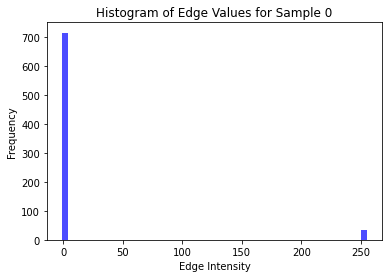

ValueError: cannot reshape array of size 16340 into shape (127,newaxis)

In [34]:
edge_data = pd.read_csv('canny_edge/all_edges.csv')

# Compute basic statistics
mean_edges = edge_data.mean(axis=1)  # Mean of edge values for each sample
std_edges = edge_data.std(axis=1)  # Standard deviation of edge values for each sample

# Display the statistics
print(f"Mean edge values:\n{mean_edges}\n")
print(f"Standard deviation of edge values:\n{std_edges}\n")

# Histogram of edge values for a specific sample
sample_index = 0  # Change this index to analyze different samples
plt.hist(edge_data.iloc[sample_index], bins=50, color='blue', alpha=0.7)
plt.title(f"Histogram of Edge Values for Sample {sample_index}")
plt.xlabel("Edge Intensity")
plt.ylabel("Frequency")
plt.show()

# Heatmap of edge values for the same sample
plt.imshow(edge_data.iloc[sample_index].values.reshape((int(np.sqrt(edge_data.shape[1])), -1)), cmap='gray')
plt.title(f"Edge Map for Sample {sample_index}")
plt.colorbar(label='Edge Intensity')
plt.show()

In [40]:
def analyze_loopiness(input_directory, output_directory):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate over all the images in the directory
    for filename in os.listdir(input_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Read the image
            img_path = os.path.join(input_directory, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Convert grayscale image to color (RGB) for visualization
            color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            
            # Apply thresholding to get a binary image
            _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
            
            # Find contours
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Filter contours based on loopiness criteria (e.g., area, circularity)
            loopiness_features = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                
                # Define loopiness based on circularity
                if circularity > 0.001:  # Adjust this threshold as needed
                    loopiness_features.append(circularity)
                    # Draw the contour on the color image with a thick red line
                    cv2.drawContours(color_image, [contour], -1, (0,0,255), 3)
            
            # Process loopiness features (e.g., count loops, average circularity)
            loop_count = len(loopiness_features)
            avg_circularity = np.mean(loopiness_features) if loopiness_features else 0
            
            print(f"{filename}: Loop count = {loop_count}, Average circularity = {avg_circularity}")

            # Save the result with prominent loopiness indication
            output_image_path = os.path.join(output_directory, filename)
            cv2.imwrite(output_image_path, color_image)

# Example usage
input_directory = 'cleaned_characters/student_1'
output_directory = 'loop_analysis'
analyze_loopiness(input_directory, output_directory)


char-213.jpg: Loop count = 2, Average circularity = 0.16077916902350958
char-95.jpg: Loop count = 1, Average circularity = 0.11229418585306686
char-56.jpg: Loop count = 5, Average circularity = 0.3796376009198129
char-42.jpg: Loop count = 2, Average circularity = 0.14291317292516706
char-159.jpg: Loop count = 9, Average circularity = 0.2188738488751241
char-165.jpg: Loop count = 3, Average circularity = 0.28897640908730277
char-171.jpg: Loop count = 1, Average circularity = 0.0309741100225652
char-429.jpg: Loop count = 12, Average circularity = 0.30221352816949004
char-367.jpg: Loop count = 1, Average circularity = 0.19404435315409954
char-401.jpg: Loop count = 5, Average circularity = 0.37324952986884974
char-415.jpg: Loop count = 4, Average circularity = 0.21620682476650424
char-373.jpg: Loop count = 2, Average circularity = 0.11779924627582845
char-398.jpg: Loop count = 1, Average circularity = 0.22765640822879726
char-414.jpg: Loop count = 6, Average circularity = 0.293191895751333

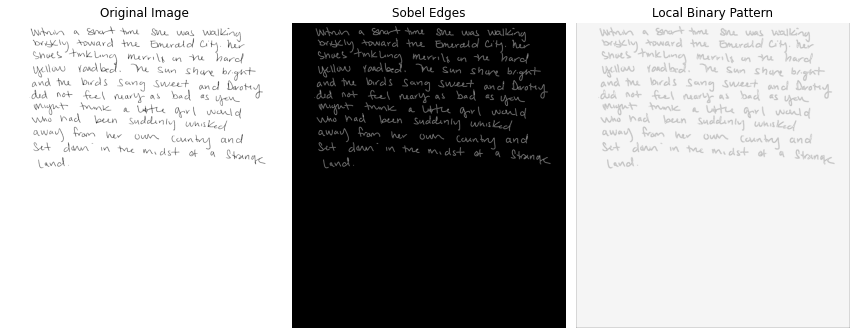

array([[-0.14849324, -9.89799262],
       [-0.14849324, -9.30517525],
       [-0.14849324, -8.71235788],
       ...,
       [-0.14849324, -8.71235788],
       [-0.14849324, -9.30517525],
       [-0.14849324, -9.89799262]])

In [41]:
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.filters import sobel
from skimage.color import rgb2gray
import numpy as np

def handwriting_features_with_visualization(img):
    # Convert to grayscale if the image is colored
    if len(img.shape) == 3:
        img = rgb2gray(img)
    
    # Calculate Sobel edges as texture features
    edges = sobel(img)
    texture_features_sobel = edges.flatten().reshape(-1, 1)
    
    # Calculate Local Binary Pattern (LBP) as additional texture features
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, 'uniform')
    texture_features_lbp = lbp.flatten().reshape(-1, 1)
    
    # Combine Sobel and LBP features
    features = np.hstack((texture_features_sobel, texture_features_lbp))
    
    # Normalize features
    features -= features.mean(axis=0)
    features /= features.std(axis=0)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Sobel Edges')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(lbp, cmap='gray')
    plt.title('Local Binary Pattern')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    return features

handwriting_features_with_visualization(preprocessed_image)

In [45]:
def extract_words_from_image(preprocessed_image, output_directory, space_threshold=50):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Convert to grayscale if necessary
    if len(preprocessed_image.shape) == 3:
        gray = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = preprocessed_image

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right
    boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: b[1][0]))

    # Merge contours that are close to each other horizontally to form words
    word_contours = []
    current_word = []
    current_x = 0

    for contour, bbox in zip(contours, boundingBoxes):
        x, y, w, h = bbox
        if current_word and (x - current_x > space_threshold):
            word_contours.append(np.vstack(current_word))
            current_word = []
        current_word.append(contour)
        current_x = x + w

    # Add the last word
    if current_word:
        word_contours.append(np.vstack(current_word))

    # Save each word as an image
    for i, word_contour in enumerate(word_contours):
        x, y, w, h = cv2.boundingRect(word_contour)
        word_image = preprocessed_image[y:y+h, x:x+w]
        cv2.imwrite(f"{output_directory}/word_{i+1}.png", word_image)

# Example usage
# Assume preprocessed_image is your loaded and preprocessed image variable
output_directory = 'words'  # Directory where individual word images will be saved
extract_words_from_image(preprocessed_image, output_directory)
